In [156]:
# *** Import required libraries

import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from functions import get_roles, favorite_covered, make_match_key, mark_bad_pair
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load

In [5]:
# *** Set data paths for each input file
# project_path = os.path.dirname(os.path.abspath(__file__)) <-- won't work in Jupyter, but will in script
# Comment out project_path = os.getcwd() when copying code back to main.py
project_path = os.getcwd()
data = 'data/csv-raw/'

data_path_2023_2024_lines = os.path.join(
    project_path, data,
    '2023_2024_lines.txt'
)
data_path_merged_cfb_historical_odds = os.path.join(
    project_path, data,
    'merged_cfb_historical_odds.csv'
)
data_path_cfb_box_scores = os.path.join(
    project_path, data,
    'cfb_box_scores_2007_2024.csv'
)
data_path_stad_capacity = os.path.join(
    project_path, data,
    'stadium_capacity.csv'
)

In [6]:
# *** Read in lines from 2023 and 2024 seasons' odds into DataFrame
stats_23_24 = pd.read_csv(data_path_2023_2024_lines, sep='\t')

teams_list = []

# *** Clean school names to make them consistent across all datasets
for team in stats_23_24['Team']:
    team = team.replace('NIU', 'Northern Illinois')
    team = team.replace('WKU', 'Western Kentucky')
    team = team.replace('Uconn', 'Connecticut')
    team = team.replace('ECU', 'East Carolina')
    teams_list.append(team)
stats_23_24['Team'] = pd.Series(teams_list)
stats_23_24.drop(columns=['Unnamed: 10'], axis=1, inplace=True)
stats_23_24.rename(columns={'Spread': 'spread'}, inplace=True)

In [7]:
# *** Strip out 'vs ' and ' @' from in front of the Opponent teams
# Take each modified team and populate into new columns for home and away teams
home_teams = []
away_teams = []

for index, row in stats_23_24.iterrows():
    opponent = row['Opponent']
    team = row['Team']
    
    if isinstance(opponent, str) and 'vs ' in opponent:
        stats_23_24.at[index, 'Opponent'] = opponent.replace('vs ', '')
        home_teams.append(team)
        away_teams.append(opponent.replace('vs ', ''))
    elif isinstance(opponent, str) and '@ ' in opponent:
        stats_23_24.at[index, 'Opponent'] = opponent.replace('@ ', '')
        home_teams.append(opponent.replace('@ ', ''))
        away_teams.append(team)
    else:
        home_teams.append(None)
        away_teams.append(None)

stats_23_24['home'] = pd.Series(home_teams)
stats_23_24['away'] = pd.Series(away_teams)


In [8]:
# *** Populate list with each unique team in 'Team' column
fbs_teams_list = stats_23_24['Team'].unique().tolist()

In [9]:
# *** Populate teams in the 'away_team' column that are not FBS with the 'FCS' designation
for index, row in stats_23_24.iterrows():
    if row['away'] not in fbs_teams_list:
        stats_23_24.at[index, 'away'] = 'FCS'
    if row['home'] not in fbs_teams_list:
        stats_23_24.at[index, 'home'] = 'FCS'
fcs_teams_stats_away = stats_23_24[stats_23_24['away'] == 'FCS'].index
fcs_teams_stats_home = stats_23_24[stats_23_24['home'] == 'FCS'].index

In [10]:
# *** Drop rows from stats_23_24 DataFrame that have 'FCS' for 'away'
# using the indices of each row that has 'FCS' for 'Opponent'
stats_23_24.drop(fcs_teams_stats_away, inplace=True, errors='ignore')
stats_23_24.drop(fcs_teams_stats_home, inplace=True, errors='ignore')
stats_23_24 = stats_23_24.reset_index(drop=True)

In [11]:
# *** Convert 'full_date' column to date
stats_23_24.rename(columns={'Date': 'full_date'}, inplace=True)
stats_23_24['full_date'] = pd.to_datetime(stats_23_24['full_date'], format='%d-%b-%y')

In [12]:
# *** Give each matchup a 'game_id' consisting of the teams involved and the date
# so as to be able to delete the duplicate matchup
stats_23_24['match_key'] = stats_23_24.apply(
    make_match_key, axis=1
)
stats_23_24['game_id'] = stats_23_24['full_date'].astype(str) + '_' + stats_23_24['match_key']


In [13]:
# *** Drop duplicate matchups
stats_23_24_new = stats_23_24.drop_duplicates(subset='game_id').reset_index(drop=True)

In [14]:
# *** Rename over/under columns
stats_23_24_new.rename(columns={'OU': 'ou', 'Total': 'ou_total'}, inplace=True, errors='ignore')

In [15]:
# *** Split out 'Score' column into 'home_score' and 'away_score' columns
home_scores = []
away_scores = []

for _, row in stats_23_24_new.iterrows():
    scores = re.findall(r'(\d+)', row['Score'])
    if len(scores) != 2:
        home_scores.append(None)
        away_scores.append(None)
        continue
    home_score = int(scores[0])
    away_score = int(scores[1])
    if row['Team'] == row['home'] and row['Result'] == 'W':
        home_scores.append(home_score)
        away_scores.append(away_score)
    elif row['Team'] == row['away'] and row['Result'] == 'L':
        home_scores.append(home_score)
        away_scores.append(away_score)
    else:
        home_scores.append(away_score)
        away_scores.append(home_score)
    

stats_23_24_new['home_score'] = pd.Series(home_scores)
stats_23_24_new['away_score'] = pd.Series(away_scores)

In [16]:
# *** Drop unneeded columns
stats_23_24_new.drop(['Team', 'Opponent'], inplace=True, axis=1, errors='ignore')

In [17]:
# *** Determine who the favorite/underdog is based on spread value (+/-) and home/away
stats_23_24_new[['fav_side', 'dog_side']] = stats_23_24_new.apply(get_roles, axis=1)

In [18]:
# *** Calculate absolute value of 'spread' value and if the favorite covered the spread or not
stats_23_24_new['spread'] = stats_23_24_new['spread'].abs()
stats_23_24_new['favorite_covered'] = stats_23_24_new.apply(favorite_covered, axis=1)

In [19]:
for i in range(len(stats_23_24_new)):

    c1 = stats_23_24_new.loc[i, 'away_score']
    c2 = stats_23_24_new.loc[i, 'home_score']
    fav_side_home = stats_23_24_new.loc[i, 'fav_side'] == 'home'
    fav_side_away = stats_23_24_new.loc[i, 'fav_side'] == 'away'

    if (c1 + c2) > stats_23_24_new.loc[i, 'ou_total']:
        stats_23_24_new.loc[i, 'ou'] = 'O'
    elif (c1 + c2) < stats_23_24_new.loc[i, 'ou_total']:
        stats_23_24_new.loc[i, 'ou'] = 'U'
    else:
        stats_23_24_new.loc[i, 'ou'] = 'E'
    
    if (c1 > c2) and (fav_side_home):
        stats_23_24_new.loc[i, 'spread_away_cover'] = 'y'
        stats_23_24_new.loc[i, 'spread_home_cover'] = 'n'
    elif (c1 > c2) and (fav_side_away):
        if (c1 - c2) > stats_23_24_new.loc[i, 'spread']:
            stats_23_24_new.loc[i, 'spread_away_cover'] = 'y'
            stats_23_24_new.loc[i, 'spread_home_cover'] = 'n'
        else:
            stats_23_24_new.loc[i, 'spread_away_cover'] = 'n'
            stats_23_24_new.loc[i, 'spread_home_cover'] = 'y'
    elif (c2 > c1) and fav_side_home:
        if (c2 - c1) > stats_23_24_new.loc[i, 'spread']:
            stats_23_24_new.loc[i, 'spread_home_cover'] = 'y'
            stats_23_24_new.loc[i, 'spread_away_cover'] = 'n'
        else:
            stats_23_24_new.loc[i, 'spread_home_cover'] = 'n'
            stats_23_24_new.loc[i, 'spread_away_cover'] = 'y'
    elif (c2 > c1) and fav_side_away:
        if (c2 - c1) > stats_23_24_new.loc[i, 'spread']:
            stats_23_24_new.loc[i, 'spread_home_cover'] = 'y'
            stats_23_24_new.loc[i, 'spread_away_cover'] = 'n'
        else:
            stats_23_24_new.loc[i, 'spread_home_cover'] = 'n'
            stats_23_24_new.loc[i, 'spread_away_cover'] = 'y'
    else:
        stats_23_24_new.loc[i, 'spread_home_cover'] = 'eq'
        stats_23_24_new.loc[i, 'spread_away_cover'] = 'eq'

In [20]:
stats_23_24_new.drop(columns=['Game', 'Result', 'Score', 'ATS'], axis=1, inplace=True)

In [21]:
stats_23_24_new['ml_fav'] = pd.Series(dtype='Int64')
stats_23_24_new['ml_dog'] = pd.Series(dtype='Int64')

In [22]:
# *** Load historical odds DataFrame
hist_odds = pd.read_csv(data_path_merged_cfb_historical_odds)
hist_odds['Season'] = pd.to_numeric(
    hist_odds['Season'], errors='coerce').fillna(0).astype(int)
hist_odds = hist_odds.drop(
    ['1st', '2nd', '3rd', '4th'], axis=1, errors='ignore')

In [23]:
# Clean team names, putting spaces in between words of school name
# correcting Miami Florida and Miami Ohio to Miami FL and Miami OH to
# make it consistent across the other datasets.  Also changing 'St' to 'State'
teams_list = []
for team in hist_odds['Team']:
    team = str(team)
    team = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', team)
    team = team.replace(' U', '')
    team = team.replace('Miami Florida', 'Miami FL')
    team = team.replace('Miami Ohio', 'Miami OH')
    team = team.replace("ULMonroe", "Louisiana Monroe")
    team = team.replace("ULLafayette", "Louisiana Lafayette")
    team = re.sub(r'St$', 'State', team)
    team = re.sub(r'Kent$', 'Kent State', team)
    team = team.replace('So Mississippi', 'Southern Miss')
    teams_list.append(team)
hist_odds['Team'] = pd.Series(teams_list)

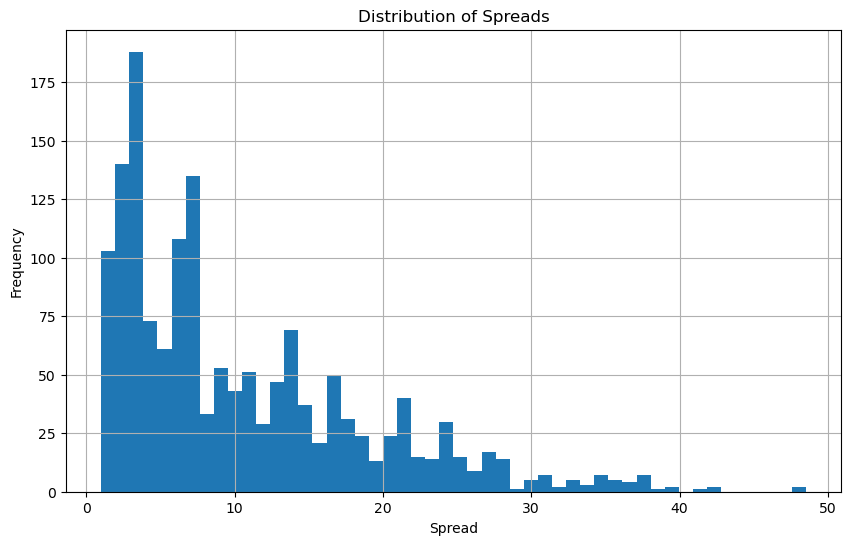

In [155]:
stats_23_24_new.hist(column='spread', bins=50, figsize=(10, 6))
plt.title('Distribution of Spreads')
plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Apply it
hist_odds = mark_bad_pair(hist_odds)

In [25]:
# *** Combine both rows in a contest in the hist_odds DataFrame into one row

hist_odds['month'] = pd.Series(dtype='Int64')
hist_odds['day'] = pd.Series(dtype='Int64')

hist_odds['fav_side'] = pd.Series(dtype='str')
hist_odds['dog_side'] = pd.Series(dtype='str')

for i in range(0, len(hist_odds) - 1, 2):
    raw_date_str = str(hist_odds.loc[i, 'Date']).zfill(4)
    hist_odds.loc[i, 'raw_date_str'] = raw_date_str
    hist_odds.loc[i, 'month'] = int(raw_date_str[:-2])
    hist_odds.loc[i, 'day'] = int(raw_date_str[-2:])
    hist_odds.loc[i, 'full_date'] = (str(hist_odds.loc[i, 'Season']) + '-' + str(hist_odds.loc[i, 'month']) + '-' + str(hist_odds.loc[i, 'day']))

    hist_odds.loc[i, 'away_score'] = hist_odds.loc[i, 'Final']
    hist_odds.loc[i, 'home_score'] = hist_odds.loc[i + 1, 'Final']

    hist_odds.loc[i, 'away'] = hist_odds.loc[i, 'Team']
    hist_odds.loc[i, 'home'] = hist_odds.loc[i + 1, 'Team']

    c1 = pd.to_numeric(hist_odds.loc[i, 'Close'], errors='coerce')
    c2 = pd.to_numeric(hist_odds.loc[i + 1, 'Close'], errors='coerce')

    c3 = hist_odds.loc[i, 'away_score']
    c4 = hist_odds.loc[i, 'home_score']

    # Only proceed if both c1 and c2 are not NaN
    # If either c1 or c2 is NaN, skip this row
    # *** Apply favorite for home or away to historical odds
    # and combine over/under and spread on to one line depending on which number is higher
    # (the spread number is ALWAYS going to be less than the over/under)
    if not (np.isnan(c1) or np.isnan(c2)):
        if c1 > c2:
            hist_odds.loc[i, 'ou_total'] = c1
            hist_odds.loc[i, 'spread'] = c2
            # Added next 4 rows
            if c2 == 0:
                hist_odds.loc[i, 'fav_side'] = 'none'
                hist_odds.loc[i, 'dog_side'] = 'none'
            else:
                hist_odds.loc[i, 'fav_side'] = 'home'
                hist_odds.loc[i, 'dog_side'] = 'away'
        else:
            hist_odds.loc[i, 'ou_total'] = c2
            hist_odds.loc[i, 'spread'] = c1
            # Added next 4 rows
            if c1 == 0:
                hist_odds.loc[i, 'fav_side'] = 'none'
                hist_odds.loc[i, 'dog_side'] = 'none'
            else:
                hist_odds.loc[i, 'fav_side'] = 'away'
                hist_odds.loc[i, 'dog_side'] = 'home'

        if (c3 + c4) > hist_odds.loc[i, 'ou_total']:
            hist_odds.loc[i, 'ou'] = 'O'
        elif (c3 + c4) < hist_odds.loc[i, 'ou_total']:
            hist_odds.loc[i, 'ou'] = 'U'
        else:
            hist_odds.loc[i, 'ou'] = 'E'

In [26]:
# *** Populate teams in the 'away_team' column that are not FBS with the 'FCS' designation
for index, row in hist_odds.iterrows():
    if row['away'] not in fbs_teams_list:
        hist_odds.at[index, 'away'] = 'FCS'
    if row['home'] not in fbs_teams_list:
        hist_odds.at[index, 'home'] = 'FCS'
fcs_teams_stats_away = hist_odds[hist_odds['away'] == 'FCS'].index
fcs_teams_stats_away = hist_odds[hist_odds['home'] == 'FCS'].index

In [27]:
# *** Drop rows from stats_23_24 DataFrame that have 'FCS' for 'away_team'
# using the indices of each row that has 'FCS' for 'Opponent'
hist_odds.drop(fcs_teams_stats_away, inplace=True, errors='ignore')
hist_odds.drop(fcs_teams_stats_home, inplace=True, errors='ignore')
hist_odds = hist_odds.reset_index(drop=True)

In [28]:
# *** Mark whether the home or away team covered the spread
for i in range(len(hist_odds)):        
    if (c3 > c4) and (hist_odds.loc[i, 'fav_side'] == 'home'):
        hist_odds.loc[i, 'spread_away_cover'] = 'y'
        hist_odds.loc[i, 'spread_home_cover'] = 'n'
    elif (c3 > c4) and (hist_odds.loc[i, 'fav_side'] == 'away'):
        if (c3 - c4) > hist_odds.loc[i, 'spread']:
            hist_odds.loc[i, 'spread_away_cover'] = 'y'
            hist_odds.loc[i, 'spread_home_cover'] = 'n'
        elif (c3 - c4) < hist_odds.loc[i, 'spread']:
            hist_odds.loc[i, 'spread_away_cover'] = 'n'
            hist_odds.loc[i, 'spread_home_cover'] = 'y'
        else:
            hist_odds.loc[i, 'spread_away_cover'] = 'eq'
            hist_odds.loc[i, 'spread_home_cover'] = 'eq'
            
    elif (c4 > c3) and (hist_odds.loc[i, 'fav_side'] == 'home'):
        if (c4 - c3) > hist_odds.loc[i, 'spread']:
            hist_odds.loc[i, 'spread_home_cover'] = 'y'
            hist_odds.loc[i, 'spread_away_cover'] = 'n'
        else:
            hist_odds.loc[i, 'spread_home_cover'] = 'n'
            hist_odds.loc[i, 'spread_away_cover'] = 'y'
    else:
        if (c4 - c3) > hist_odds.loc[i, 'spread']:
            hist_odds.loc[i, 'spread_home_cover'] = 'y'
            hist_odds.loc[i, 'spread_away_cover'] = 'n'
        else:
            hist_odds.loc[i, 'spread_home_cover'] = 'n'
            hist_odds.loc[i, 'spread_away_cover'] = 'y'

In [29]:
hist_odds['ML'] = pd.to_numeric(hist_odds['ML'], errors='coerce')

In [30]:
# *** Determine the money line favorite and underdog
hist_odds['ml_fav'] = pd.Series(dtype='Int64')
hist_odds['ml_dog'] = pd.Series(dtype='Int64')

for i in range(0, len(hist_odds) - 1, 2):
    if (hist_odds.loc[i, 'ML'] != 'NL') and (hist_odds.loc[i+1, 'ML'] != 'NL'):
        if hist_odds.loc[i, 'ML'] < 0:
            hist_odds.loc[i, 'ml_fav'] = hist_odds.loc[i, 'ML']
        else:
            hist_odds.loc[i, 'ml_dog'] = hist_odds.loc[i, 'ML']

        if hist_odds.loc[i+1, 'ML'] < 0:
            hist_odds.loc[i, 'ml_fav'] = hist_odds.loc[i+1, 'ML']
        else:
            hist_odds.loc[i, 'ml_dog'] = hist_odds.loc[i+1, 'ML']
        
hist_odds = hist_odds.dropna(subset=['home', 'away'], axis=0).reset_index(drop=True)
hist_odds = hist_odds.drop(['Rot', 'VH', 'Team', 'Final', 'ML', 'Close'], axis=1, errors='ignore').reset_index(drop=True)

In [31]:
# *** Create match key from teams in contest
hist_odds['match_key'] = hist_odds.apply(make_match_key, axis=1)
hist_odds['game_id'] = hist_odds['full_date'].astype(str) + '_' + hist_odds['match_key']

In [32]:
# *** Drop duplicate matchups
hist_odds = hist_odds.drop_duplicates(subset='game_id').reset_index(drop=True)

In [33]:
hist_odds['full_date'] = pd.to_datetime(hist_odds['full_date'], errors="coerce")

In [34]:
hist_odds.columns = [col.lower().strip() for col in hist_odds.columns]

In [35]:
# *** Determine if the favorite covered the spread
hist_odds['favorite_covered'] = hist_odds.apply(favorite_covered, axis=1)

In [36]:
# *** Drop unneedefd columns from historical odds dataset
hist_odds.drop(['season', 'date', 'month', 'day', 'raw_date_str'], axis=1, inplace=True, errors='ignore')

In [37]:
# *** Calculate mean of existing money line favorites and underdogs by spread
# to impute in missing money line fields
# Only include rows where both ml_fav and ml_dog exist
valid_rows = hist_odds[hist_odds['ml_fav'].notna() & hist_odds['ml_dog'].notna()]

spread_means = valid_rows.groupby('spread').agg({
    'ml_fav': 'mean',
    'ml_dog': 'mean'
}).rename(columns={
    'ml_fav': 'mean_fav_ml',
    'ml_dog': 'mean_dog_ml'
})
spread_means['spread'] = spread_means.index

In [38]:
spread_means.dropna(inplace=True, axis=0)

In [39]:
spread_means.loc[0.0, ['mean_fav_ml']] = -110
spread_means.loc[0.0, ['mean_dog_ml']] = -110

In [40]:
# Function to impute missing moneylines in historical odds dataset
def fill_missing_mls(row):
    spread_val = row['spread']
    if pd.isna(spread_val) or spread_val not in spread_means.index:
        return row  # No lookup if spread is missing or not in index

    means = spread_means.loc[spread_val]

    if pd.isna(row['ml_fav']):
        row['ml_fav'] = means['mean_fav_ml']
    if pd.isna(row['ml_dog']):
        row['ml_dog'] = means['mean_dog_ml']

    return row

In [41]:
# *** Function to impute all moneyline values for 2023-24 odds dataset
def fill_all_mls(row):
    spread_val = row['spread']
    if pd.isna(spread_val) or spread_val not in spread_means.index:
        return row  # No lookup if spread is missing or not in index
    means = spread_means.loc[spread_val]

    if pd.isna(row['ml_fav']):
        row['ml_fav'] = means['mean_fav_ml']
    if pd.isna(row['ml_dog']):
        row['ml_dog'] = means['mean_dog_ml']

    return row

In [42]:
stats_23_24_new = stats_23_24_new.apply(fill_all_mls, axis=1)

In [43]:
hist_odds = hist_odds.apply(fill_missing_mls, axis=1)

In [44]:
stats_23_24_new.dropna(subset=['ml_fav', 'ml_dog'], inplace=True)

In [45]:
hist_odds.dropna(subset=['ml_fav', 'ml_dog'], inplace=True)

In [46]:
ml_conv = spread_means.copy().reset_index(drop=True)

In [47]:
ml_conv.rename(columns={'mean_fav_ml': 'ml_fav', 'mean_dog_ml': 'ml_dog'}, inplace=True)

In [48]:
stats_23_24_new['spread'] = stats_23_24_new['spread'].abs()

In [49]:
# *** Ensure all columns in the 'ml_conv' DataFrame are numeric and that 'fav_ml' and 'dog_ml'
# columns are integers
ml_conv['spread'] = pd.to_numeric(ml_conv['spread'])
ml_conv['ml_fav'] = pd.to_numeric(ml_conv['ml_fav']).round()
ml_conv['ml_dog'] = pd.to_numeric(ml_conv['ml_dog']).round()

In [50]:
ml_conv.dropna().reset_index(drop=True)

,ml_fav,ml_dog,spread
0,-110.0,-110.0,0.0
1,-181.0,416.0,1.0
2,-324.0,589.0,1.5
3,-475.0,1153.0,2.0
4,-378.0,412.0,2.5
...,...,...,...
83,-110.0,50000.0,47.0
84,-103.0,50000.0,47.5
85,-485.0,36652.0,48.5
86,-1600.0,7000.0,50.0


In [51]:
# Read in cfb_box_scores_2004_2024.csv to DataFrame
box_scores = pd.read_csv(data_path_cfb_box_scores)
# Drop columns not needed for analysis
box_scores.drop(['rank_away', 'rank_home', 'q1_away', 'q2_away',
                              'q3_away', 'q4_away', 'ot_away', 'q1_home',
                              'q2_home', 'q3_home', 'q4_home', 'ot_home',
                              'tv'], errors='ignore', inplace=True, axis=1)
# Clean school names to make them consistent across all datasets
teams_list = []
for team in box_scores['home']:
    team = team.replace('(OH)', 'OH')
    team = team.replace('(FL)', 'FL')
    team = team.replace('UL-Lafayette', 'Louisiana Lafayette')
    team = team.replace('UL-Monroe', 'Louisiana Monroe')
    team = team.replace('Florida Atlantic', 'FAU')
    team = team.replace('East Carolina', 'ECU')
    team = team.replace('Sam Houston State', 'Sam Houston')
    teams_list.append(team)
box_scores['home'] = teams_list
teams_list = []
for team in box_scores['away']:
    team = team.replace('(OH)', 'OH')
    team = team.replace('(FL)', 'FL')
    team = team.replace('UL-Lafayette', 'Louisiana Lafayette')
    team = team.replace('UL-Monroe', 'Louisiana Monroe')
    team = team.replace('Florida Atlantic', 'FAU')
    team = team.replace('East Carolina', 'ECU')
    team = team.replace('Sam Houston State', 'Sam Houston')
    teams_list.append(team)
box_scores['away'] = teams_list

In [52]:
# *** Convert 'date' column in box_scores DataFrame to date
box_scores['full_date'] = pd.to_datetime(box_scores['full_date'], errors="coerce")

In [53]:
# *** Create match_key column consisting of both teams
box_scores['match_key'] = box_scores.apply(make_match_key, axis=1)
box_scores['game_id'] = box_scores['full_date'].astype(str) + '_' + box_scores['match_key']

In [54]:
# *** Locate non-FBS teams and mark them as 'FCS'
for index, row in box_scores.iterrows():
    if row['away'] not in fbs_teams_list:
        box_scores.at[index, 'away'] = 'FCS'
    if row['home'] not in fbs_teams_list:
        box_scores.at[index, 'home'] = 'FCS'
fcs_teams_stats_away = box_scores[box_scores['away'] == 'FCS'].index
fcs_teams_stats_home = box_scores[box_scores['home'] == 'FCS'].index

In [55]:
# *** Drop rows from stats_23_24 DataFrame that have 'FCS' for 'away_team'
# using the indices of each row that has 'FCS' for 'Opponent'
box_scores.drop(fcs_teams_stats_away, inplace=True, errors='ignore')
box_scores.drop(fcs_teams_stats_home, inplace=True, errors='ignore')
box_scores = box_scores.reset_index(drop=True)

In [56]:
# *** Impute 'n' for games where they are not rivalries
for i in range(0, len(box_scores)):
    if pd.isna(box_scores.loc[i, 'rivalry']):
        box_scores.loc[i, 'rivalry'] = 'n'
        

In [57]:
# *** Load stadium capacity into DataFrame to use for imputation of box_scores['capacity'] column
stad_capacity = pd.read_csv(data_path_stad_capacity)
stad_capacity = stad_capacity.drop('Stadium', axis=1)
stad_capacity.set_index('home', inplace=True)

In [58]:
# *** Impute capacity from stad_capacity into box_scores
for i, row in box_scores.iterrows():
    home_team = row['home']
    capacity = stad_capacity.loc[home_team, 'capacity']
    if pd.isna(box_scores.loc[i, 'capacity']):
        box_scores.at[i, 'capacity'] = capacity

# Convert to 'capacity' to numeric
box_scores['capacity'] = pd.to_numeric(box_scores['capacity'], errors='coerce').astype('Int64')

In [59]:
# *** Calculate mean on attendance for each team
attendance_means = box_scores.groupby('home').agg({
    'attendance': 'mean',
})
attendance_means['home'] = attendance_means.index
attendance_means['attendance'] = attendance_means['attendance'].round()

In [60]:
# *** Impute attendance means for missing games
for i, row in box_scores.iterrows():
    attend_home = row['home']
    attendance = attendance_means.loc[attend_home, 'attendance']
    if pd.isna(box_scores.loc[i, 'attendance']):
        box_scores.at[i, 'attendance'] = attendance

In [61]:
# *** Calculate percentage of attendance/capacity
for i, row in box_scores.iterrows():
    attend_percent = row['attendance'] / row['capacity']
    box_scores['attend_percent']  = attend_percent

In [62]:
stats_23_24_new.reset_index(inplace=True)

In [63]:
hist_odds.reset_index(inplace=True)

In [64]:
box_scores.reset_index(inplace=True)

In [65]:
stats_23_24_new.sort_values('game_id', axis=0, inplace=True)

In [66]:
hist_odds.sort_values('game_id', axis=0, inplace=True)

In [67]:
box_scores.sort_values('game_id', axis=0, inplace=True)

In [68]:
cols_to_fix = ['home_score', 'away_score']

hist_odds[cols_to_fix] = hist_odds[cols_to_fix].astype('Int64')
stats_23_24_new[cols_to_fix] = stats_23_24_new[cols_to_fix].astype('Int64')

In [69]:
# Merge stats_23_24 and hist_ods DataFrames
merged_odds_df = pd.concat([hist_odds, stats_23_24_new])

In [70]:
# *** Create match_key column consisting of both teams
merged_odds_df['match_key'] = merged_odds_df.apply(make_match_key, axis=1)
merged_odds_df['game_id'] = merged_odds_df['full_date'].astype(str) + '_' + merged_odds_df['match_key']

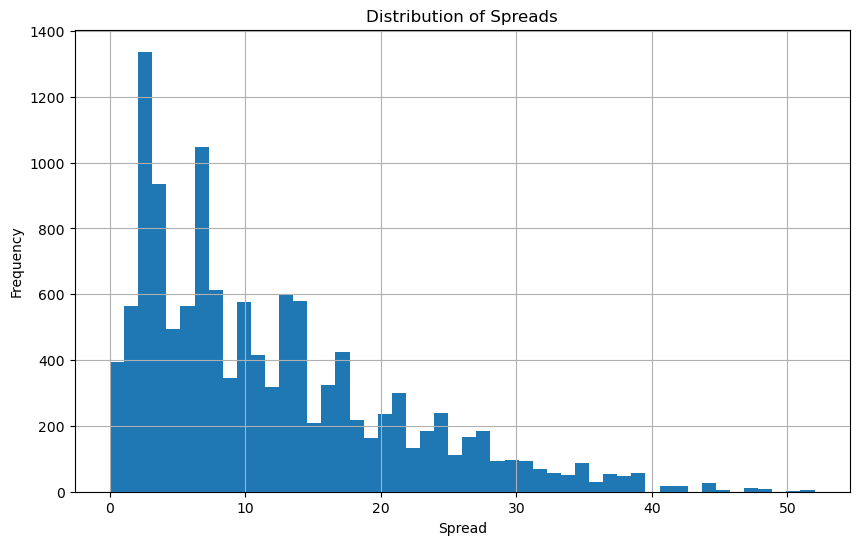

In [152]:
merged_odds_df.hist(column='spread', bins=50, figsize=(10, 6))
plt.title('Distribution of Spreads')
plt.xlabel('Spread')
plt.ylabel('Frequency')
plt.show()

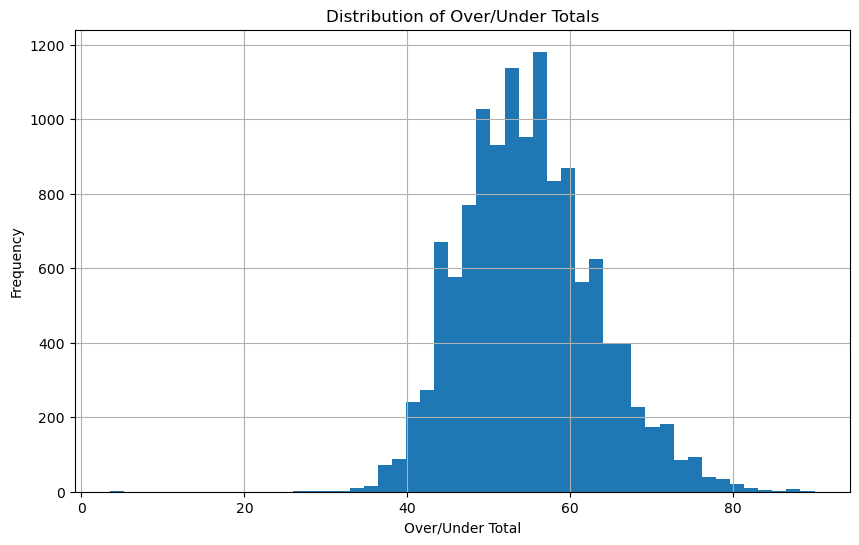

In [153]:
merged_odds_df.hist(column='ou_total', bins=50, figsize=(10, 6))
plt.title('Distribution of Over/Under Totals')
plt.xlabel('Over/Under Total')
plt.ylabel('Frequency')
plt.show()

In [71]:
# Merge odds and box scores DataFrames
# merged_df = box_scores.merge(merged_odds_df, how='inner', left_index=True, right_index=True)
merged_df = box_scores.merge(merged_odds_df, how='inner', on='game_id')

In [72]:
# Write separate and merged DataFrames to new CSV files
stats_23_24_new.to_csv('data/csv-clean/stats_23_24_new.csv')

In [73]:
box_scores.to_csv('data/csv-clean/box_scores.csv')

In [74]:
hist_odds.to_csv('data/csv-clean/hist_odds.csv')

In [75]:
ml_conv.to_csv('data/csv-clean/ml_conv.csv')

In [76]:
merged_odds_df.to_csv('data/csv-clean/merged_odds_df.csv')

In [77]:
merged_df.to_csv('data/csv-clean/merged_df.csv')

In [78]:
%history -f my_history.txt

In [169]:
numeric_df = X.select_dtypes(include=[np.number])
numeric_df = numeric_df.dropna(axis=1, how='all')

In [170]:
numeric_df.head()

,ou_total,spread,home_avg,away_avg,home_yards_avg,away_yards_avg,home_pass_yards_avg,away_pass_yards_avg,home_first_downs_avg,away_first_downs_avg,...,conf_away_acc,conf_away_big10,conf_away_big12,conf_away_cusa,conf_away_ind,conf_away_mac,conf_away_mwc,conf_away_pac12,conf_away_sec,conf_away_sun-belt
0,53.5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,49.5,30.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,45.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,44.0,19.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,53.5,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0


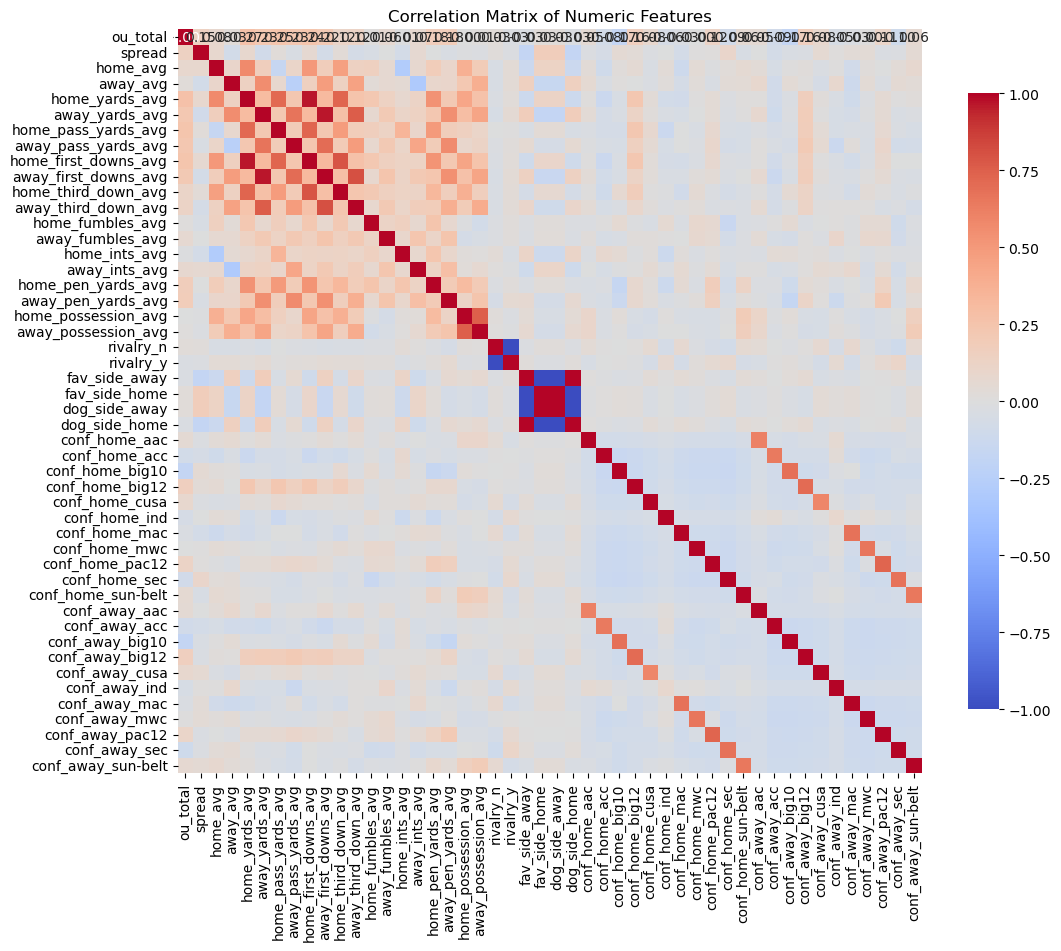

In [171]:
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numeric Features')
plt.show()

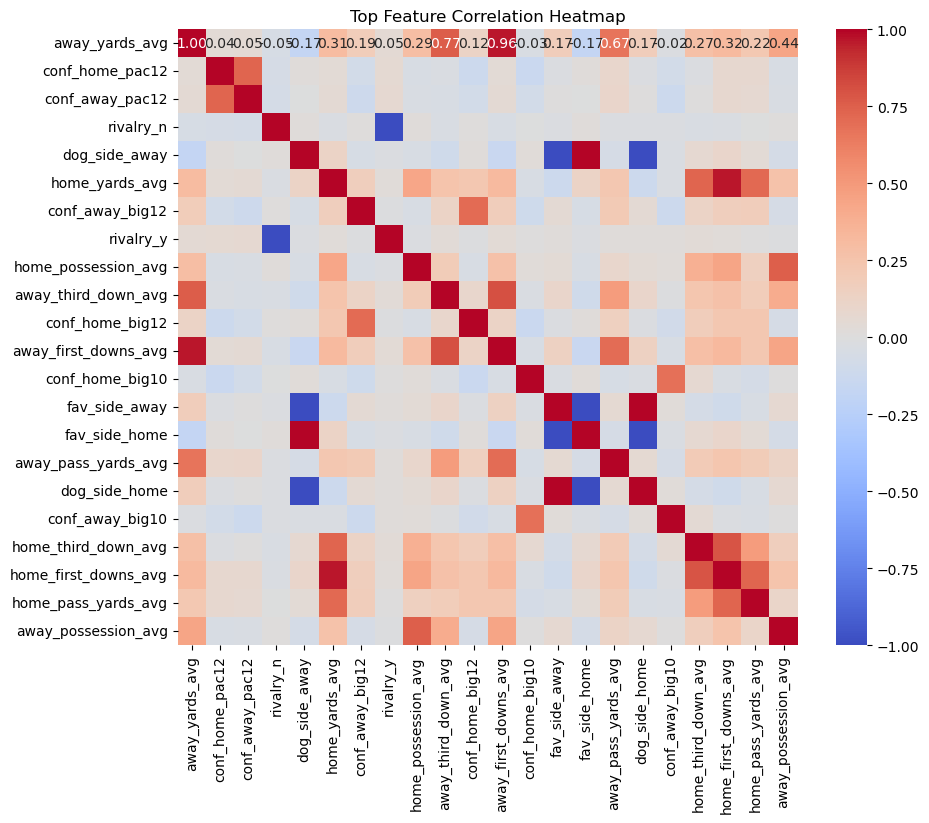

In [172]:
corr_matrix = numeric_df.corr().abs()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = upper_tri.stack().sort_values(ascending=False)

top_features = list(set([i for tup in high_corr_pairs.head(20).index for i in tup]))
top_corr_matrix = numeric_df[top_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(top_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top Feature Correlation Heatmap")
plt.show()


In [173]:
top_corr_df = pd.DataFrame(top_corr_matrix)

In [ ]:
high_corr_pairs_df = (
    top_corr_matrix.where(np.triu(np.ones(top_corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
high_corr_pairs_df.columns = ['Feature A', 'Feature B', 'Correlation']
high_corr_pairs_df.sort_values(by='Correlation', ascending=False, inplace=True)

In [174]:
high_corr_df = top_corr_df[top_corr_df.abs() > 0.8].stack().reset_index()
high_corr_df.columns = ['Feature1', 'Feature2', 'Correlation']

In [175]:
high_corr_df.head(40)

,Feature1,Feature2,Correlation
0,away_yards_avg,away_yards_avg,1.000000
1,away_yards_avg,away_first_downs_avg,0.963390
2,conf_home_pac12,conf_home_pac12,1.000000
3,conf_away_pac12,conf_away_pac12,1.000000
4,rivalry_n,rivalry_n,1.000000
5,rivalry_n,rivalry_y,-1.000000
6,dog_side_away,dog_side_away,1.000000
7,dog_side_away,fav_side_away,-1.000000
8,dog_side_away,fav_side_home,1.000000
9,dog_side_away,dog_side_home,-1.000000


In [176]:
top_corr_df.head(50)

,away_yards_avg,conf_home_pac12,conf_away_pac12,rivalry_n,dog_side_away,home_yards_avg,conf_away_big12,rivalry_y,home_possession_avg,away_third_down_avg,...,conf_home_big10,fav_side_away,fav_side_home,away_pass_yards_avg,dog_side_home,conf_away_big10,home_third_down_avg,home_first_downs_avg,home_pass_yards_avg,away_possession_avg
away_yards_avg,1.000000,0.042200,0.053274,-0.050180,-0.172525,0.309106,0.185154,0.050180,0.292067,0.765153,...,-0.034372,0.172525,-0.172525,0.671251,0.172525,-0.017566,0.274648,0.319845,0.224440,0.443340
conf_home_pac12,0.042200,1.000000,0.731948,-0.058082,0.022889,0.046097,-0.080665,0.058082,-0.043404,-0.029140,...,-0.134019,-0.022889,0.022889,0.086376,-0.022889,-0.081152,-0.017120,0.076215,0.072515,-0.043479
conf_away_pac12,0.053274,0.731948,1.000000,-0.063680,-0.001585,0.049407,-0.111056,0.063680,-0.033420,-0.042342,...,-0.084414,0.001585,-0.001585,0.096307,0.001585,-0.117581,0.004443,0.074101,0.069264,-0.037142
rivalry_n,-0.050180,-0.058082,-0.063680,1.000000,0.022046,-0.031059,0.008654,-1.000000,0.022365,-0.036325,...,-0.002412,-0.022046,0.022046,-0.021683,-0.022046,-0.017902,-0.035223,-0.031215,-0.004122,0.014155
dog_side_away,-0.172525,0.022889,-0.001585,0.022046,1.000000,0.123255,-0.053905,-0.022046,-0.039682,-0.094886,...,0.031106,-1.000000,1.000000,-0.061160,-1.000000,-0.030441,0.064403,0.099624,0.041947,-0.068653
home_yards_avg,0.309106,0.046097,0.049407,-0.031059,0.123255,1.000000,0.164125,0.031059,0.432838,0.251411,...,-0.043045,-0.123255,0.123255,0.230366,-0.123255,-0.029770,0.731498,0.961379,0.713548,0.260729
conf_away_big12,0.185154,-0.080665,-0.111056,0.008654,-0.053905,0.164125,1.000000,-0.008654,-0.041039,0.123171,...,-0.105580,0.053905,-0.053905,0.207441,0.053905,-0.119388,0.119025,0.167922,0.179081,-0.054952
rivalry_y,0.050180,0.058082,0.063680,-1.000000,-0.022046,0.031059,-0.008654,1.000000,-0.022365,0.036325,...,0.002412,0.022046,-0.022046,0.021683,0.022046,0.017902,0.035223,0.031215,0.004122,-0.014155
home_possession_avg,0.292067,-0.043404,-0.033420,0.022365,-0.039682,0.432838,-0.041039,-0.022365,1.000000,0.192735,...,0.028322,0.039682,-0.039682,0.090607,0.039682,0.025317,0.378926,0.437620,0.153684,0.751659
away_third_down_avg,0.765153,-0.029140,-0.042342,-0.036325,-0.094886,0.251411,0.123171,0.036325,0.192735,1.000000,...,-0.027046,0.094886,-0.094886,0.491448,0.094886,-0.014077,0.240864,0.266848,0.184800,0.398545


In [79]:
merged_df.dropna(inplace=True)

In [80]:
merged_df.drop(['full_date_y', 'index_y', 'index_x', 'match_key_y', 'away_y', 'home_y', 'match_key', 'away_score', 'home_score'], inplace=True, axis=1, errors='ignore')

In [81]:
merged_df.rename(columns={'match_key_x': 'match_key', 'full_date_x': 'full_date', 'home_x': 'home', 'away_x': 'away'}, inplace=True)

In [82]:
merged_df['dog_wins'] = pd.Series(dtype='Int64')
merged_df['dog_wins'] = (
    ((merged_df['dog_side'] == 'home') & (merged_df['score_home'] > merged_df['score_away'])) |
    ((merged_df['dog_side'] == 'away') & (merged_df['score_home'] < merged_df['score_away']))
).astype(int)

In [83]:
index_names = merged_df[merged_df['ou'] == 'E'].index
merged_df.drop(index_names, inplace=True)
index_names = merged_df[merged_df['favorite_covered'] == 'eq'].index
merged_df.drop(index_names, inplace=True)

In [84]:
merged_df.sort_values('full_date', inplace=True, axis=0)

In [85]:
def get_team_past_games(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0
    home_avg = home_games['score_home'].mean()
    away_avg = away_games['score_away'].mean()
        
    return home_avg, away_avg

In [86]:
def get_team_past_games_yards(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_yards_avg = home_games['total_yards_home'].mean()
    away_yards_avg = away_games['total_yards_away'].mean()
        
    return home_yards_avg, away_yards_avg

In [87]:
def get_team_past_games_rush_yards(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_rush_yards_avg = home_games['rush_yards_home'].mean()
    away_rush_yards_avg = away_games['rush_yards_away'].mean()
        
    return home_rush_yards_avg, away_rush_yards_avg

In [88]:
def get_team_past_games_pass_yards(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_pass_yards_avg = home_games['pass_yards_home'].mean()
    away_pass_yards_avg = away_games['pass_yards_away'].mean()
        
    return home_pass_yards_avg, away_pass_yards_avg

In [89]:
def get_team_past_games_first_downs(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_first_downs_avg = home_games['first_downs_home'].mean()
    away_first_downs_avg = away_games['first_downs_away'].mean()
        
    return home_first_downs_avg, away_first_downs_avg

In [90]:
def get_team_past_games_third_down(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_third_down_avg = home_games['third_down_comp_home'].mean()
    away_third_down_avg = away_games['third_down_comp_away'].mean()
        
    return home_third_down_avg, away_third_down_avg

In [91]:
def get_team_past_games_fumbles(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_fumbles_avg = home_games['fum_home'].mean()
    away_fumbles_avg = away_games['fum_away'].mean()
        
    return home_fumbles_avg, away_fumbles_avg

In [92]:
def get_team_past_games_ints(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_ints_avg = home_games['int_home'].mean()
    away_ints_avg = away_games['int_away'].mean()
        
    return home_ints_avg, away_ints_avg

In [93]:
def get_team_past_games_pen_yards(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_pen_yards_avg = home_games['pen_yards_home'].mean()
    away_pen_yards_avg = away_games['pen_yards_away'].mean()
        
    return home_pen_yards_avg, away_pen_yards_avg

In [94]:
def get_team_past_games_possession(team, current_date):
    rows_before_date = merged_df[merged_df['full_date'] < current_date]
    home_games = rows_before_date[rows_before_date['home'] == team]
    away_games = rows_before_date[rows_before_date['away'] == team]
    if len(home_games) == 0 and len(away_games) == 0:
        return 0.0   
    home_possession_avg = home_games['possession_home'].mean()
    away_possession_avg = away_games['possession_away'].mean()
        
    return home_possession_avg, away_possession_avg

In [95]:
# Add columns for averages if they don't exist
if 'home_avg' not in merged_df.columns:
    merged_df['home_avg'] = np.nan
if 'away_avg' not in merged_df.columns:
    merged_df['away_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games(home_team, current_date)
    if isinstance(result, tuple):
        home_avg, _ = result
    else:
        home_avg = result

    result = get_team_past_games(away_team, current_date)
    if isinstance(result, tuple):
        _, away_avg = result
    else:
        away_avg = result

    merged_df.at[i, 'home_avg'] = home_avg
    merged_df.at[i, 'away_avg'] = away_avg

In [96]:
# Add columns for averages if they don't exist
if 'home_yards_avg' not in merged_df.columns:
    merged_df['home_yards_avg'] = np.nan
if 'away_yards_avg' not in merged_df.columns:
    merged_df['away_yards_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_yards(home_team, current_date)
    if isinstance(result, tuple):
        home_yards_avg, _ = result
    else:
        home_yards_avg = result

    result = get_team_past_games_yards(away_team, current_date)
    if isinstance(result, tuple):
        _, away_yards_avg = result
    else:
        away_yards_avg = result

    merged_df.at[i, 'home_yards_avg'] = home_yards_avg
    merged_df.at[i, 'away_yards_avg'] = away_yards_avg

In [ ]:
# Add columns for averages if they don't exist
if 'home_rush_yards_avg' not in merged_df.columns:
    merged_df['home_rush_yards_avg'] = np.nan
if 'away_rush_yards_avg' not in merged_df.columns:
    merged_df['away_rush_yards_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_rush_yards(home_team, current_date)
    if isinstance(result, tuple):
        home_rush_yards_avg, _ = result
    else:
        home_rush_yards_avg = result

    result = get_team_past_games_rush_yards(away_team, current_date)
    if isinstance(result, tuple):
        _, away_rush_yards_avg = result
    else:
        away_rush_yards_avg = result

    merged_df.at[i, 'home_rush_yards_avg'] = home_rush_yards_avg
    merged_df.at[i, 'away_rush_yards_avg'] = away_rush_yards_avg

In [98]:
# Add columns for averages if they don't exist
if 'home_pass_yards_avg' not in merged_df.columns:
    merged_df['home_pass_yards_avg'] = np.nan
if 'away_pass_yards_avg' not in merged_df.columns:
    merged_df['away_pass_yards_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_pass_yards(home_team, current_date)
    if isinstance(result, tuple):
        home_pass_yards_avg, _ = result
    else:
        home_pass_yards_avg = result

    result = get_team_past_games_pass_yards(away_team, current_date)
    if isinstance(result, tuple):
        _, away_pass_yards_avg = result
    else:
        away_pass_yards_avg = result

    merged_df.at[i, 'home_pass_yards_avg'] = home_pass_yards_avg
    merged_df.at[i, 'away_pass_yards_avg'] = away_pass_yards_avg

In [99]:
# Add columns for averages if they don't exist
if 'home_first_downs_avg' not in merged_df.columns:
    merged_df['home_first_downs_avg'] = np.nan
if 'away_first_downs_avg' not in merged_df.columns:
    merged_df['away_first_downs_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_first_downs(home_team, current_date)
    if isinstance(result, tuple):
        home_first_downs_avg, _ = result
    else:
        home_first_downs_avg = result

    result = get_team_past_games_first_downs(away_team, current_date)
    if isinstance(result, tuple):
        _, away_first_downs_avg = result
    else:
        away_first_downs_avg = result

    merged_df.at[i, 'home_first_downs_avg'] = home_first_downs_avg
    merged_df.at[i, 'away_first_downs_avg'] = away_first_downs_avg

In [100]:
# Add columns for averages if they don't exist
if 'home_third_down_avg' not in merged_df.columns:
    merged_df['home_third_down_avg'] = np.nan
if 'away_third_down_avg' not in merged_df.columns:
    merged_df['away_third_down_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_third_down(home_team, current_date)
    if isinstance(result, tuple):
        home_third_down_avg, _ = result
    else:
        home_third_down_avg = result

    result = get_team_past_games_third_down(away_team, current_date)
    if isinstance(result, tuple):
        _, away_third_down_avg = result
    else:
        away_third_down_avg = result

    merged_df.at[i, 'home_third_down_avg'] = home_third_down_avg
    merged_df.at[i, 'away_third_down_avg'] = away_third_down_avg

In [101]:
# Add columns for averages if they don't exist
if 'home_fumbles_avg' not in merged_df.columns:
    merged_df['home_fumbles_avg'] = np.nan
if 'away_fumbles_avg' not in merged_df.columns:
    merged_df['away_fumbles_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_fumbles(home_team, current_date)
    if isinstance(result, tuple):
        home_fumbles_avg, _ = result
    else:
        home_fumbles_avg = result

    result = get_team_past_games_fumbles(away_team, current_date)
    if isinstance(result, tuple):
        _, away_fumbles_avg = result
    else:
        away_fumbles_avg = result

    merged_df.at[i, 'home_fumbles_avg'] = home_fumbles_avg
    merged_df.at[i, 'away_fumbles_avg'] = away_fumbles_avg

In [102]:
# Add columns for averages if they don't exist
if 'home_ints_avg' not in merged_df.columns:
    merged_df['home_ints_avg'] = np.nan
if 'away_ints_avg' not in merged_df.columns:
    merged_df['away_ints_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_ints(home_team, current_date)
    if isinstance(result, tuple):
        home_ints_avg, _ = result
    else:
        home_ints_avg = result

    result = get_team_past_games_ints(away_team, current_date)
    if isinstance(result, tuple):
        _, away_ints_avg = result
    else:
        away_ints_avg = result

    merged_df.at[i, 'home_ints_avg'] = home_ints_avg
    merged_df.at[i, 'away_ints_avg'] = away_ints_avg

In [103]:
# Add columns for averages if they don't exist
if 'home_pen_yards_avg' not in merged_df.columns:
    merged_df['home_pen_yards_avg'] = np.nan
if 'away_pen_yards_avg' not in merged_df.columns:
    merged_df['away_pen_yards_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_pen_yards(home_team, current_date)
    if isinstance(result, tuple):
        home_pen_yards_avg, _ = result
    else:
        home_pen_yards_avg = result

    result = get_team_past_games_pen_yards(away_team, current_date)
    if isinstance(result, tuple):
        _, away_pen_yards_avg = result
    else:
        away_pen_yards_avg = result

    merged_df.at[i, 'home_pen_yards_avg'] = home_pen_yards_avg
    merged_df.at[i, 'away_pen_yards_avg'] = away_pen_yards_avg

In [ ]:
# Add columns for averages if they don't exist
if 'home_possession_avg' not in merged_df.columns:
    merged_df['home_possession_avg'] = np.nan
if 'away_possession_avg' not in merged_df.columns:
    merged_df['away_possession_avg'] = np.nan

for i, row in merged_df.iterrows():
    home_team = row['home']
    away_team = row['away']
    current_date = row['full_date']

    result = get_team_past_games_possession(home_team, current_date)
    if isinstance(result, tuple):
        home_possession_avg, _ = result
    else:
        home_possession_avg = result

    result = get_team_past_games_possession(away_team, current_date)
    if isinstance(result, tuple):
        _, away_possession_avg = result
    else:
        away_possession_avg = result

    merged_df.at[i, 'home_possession_avg'] = home_possession_avg
    merged_df.at[i, 'away_possession_avg'] = away_possession_avg

In [105]:
pregame_cols = ['full_date', 'away', 'home', 'conf_away', 'conf_home',
                'rivalry', 'fav_side', 'dog_side', 'ou_total', 'spread', 'ml_fav',
                'ml_dog', 'home_avg', 'away_avg', 'home_yards_avg', 'away_yards_avg',
                'home_pass_yards_avg', 'away_pass_yards_avg', 'home_first_downs_avg',
                'away_first_downs_avg', 'home_third_down_avg', 'away_third_down_avg',
                'home_fumbles_avg', 'away_fumbles_avg', 'home_ints_avg', 'away_ints_avg',
                'home_pen_yards_avg', 'away_pen_yards_avg', 'home_possession_avg', 'away_possession_avg']

In [106]:
pregame_df = merged_df[pregame_cols].copy()

In [107]:
labels_df = pd.get_dummies(merged_df[['ou', 'favorite_covered', 'dog_wins']])
merged_df.drop(columns=['ou', 'favorite_covered', 'dog_wins'], inplace=True)

In [108]:
df_dummies = merged_df[['rivalry', 'fav_side', 'dog_side', 'conf_home', 'conf_away']]
df_converted = pd.get_dummies(
    df_dummies,
    prefix=None,
    dummy_na=False,
    columns=['rivalry', 'fav_side', 'dog_side', 'conf_home', 'conf_away'],
    sparse=False,
    drop_first=False,
    dtype='int64'
)

In [109]:
df_converted['game_id'] = merged_df['game_id']

In [110]:
merged_df = merged_df.merge(df_converted, how='inner', on='game_id')

In [111]:
# Train/test split for spread covered
y_spread = labels_df['favorite_covered_y']
y_ou = labels_df['ou_O']
y_w = labels_df['dog_wins']

In [112]:
merged_df.drop(columns='index', inplace=True, axis=1, errors='ignore')

In [113]:
numeric_cols = ['ou_total', 'spread', 'ml_fav',
       'ml_dog', 'home_avg', 'away_avg', 'home_yards_avg', 'away_yards_avg',
       'home_pass_yards_avg', 'away_pass_yards_avg', 'home_first_downs_avg',
       'away_first_downs_avg', 'home_third_down_avg', 'away_third_down_avg', 'home_fumbles_avg',
       'away_fumbles_avg', 'home_ints_avg', 'away_ints_avg',
       'home_pen_yards_avg', 'away_pen_yards_avg', 'home_possession_avg',
       'away_possession_avg', 'rivalry_n', 'rivalry_y',
       'fav_side_away', 'fav_side_home', 'dog_side_away', 'dog_side_home',
       'conf_home_aac', 'conf_home_acc',
       'conf_home_big10', 'conf_home_big12', 'conf_home_cusa', 'conf_home_ind',
       'conf_home_mac', 'conf_home_mwc', 'conf_home_pac12', 'conf_home_sec',
       'conf_home_sun-belt', 'conf_away_aac', 'conf_away_acc',
       'conf_away_big10', 'conf_away_big12', 'conf_away_cusa', 'conf_away_ind',
       'conf_away_mac', 'conf_away_mwc', 'conf_away_pac12', 'conf_away_sec',
       'conf_away_sun-belt']
X = merged_df[numeric_cols]

In [114]:
prediction_cols = ['full_date', 'away', 'home', 'ou_total', 'spread', 'ml_fav',
       'ml_dog', 'home_avg', 'away_avg', 'home_yards_avg', 'away_yards_avg',
       'home_pass_yards_avg', 'away_pass_yards_avg', 'home_first_downs_avg',
       'away_first_downs_avg', 'home_third_down_avg', 'away_third_down_avg', 'home_fumbles_avg',
       'away_fumbles_avg', 'home_ints_avg', 'away_ints_avg',
       'home_pen_yards_avg', 'away_pen_yards_avg', 'home_possession_avg',
       'away_possession_avg', 'rivalry_n', 'rivalry_y',
       'fav_side_away', 'fav_side_home', 'dog_side_away', 'dog_side_home',
       'conf_home_aac', 'conf_home_acc',
       'conf_home_big10', 'conf_home_big12', 'conf_home_cusa', 'conf_home_ind',
       'conf_home_mac', 'conf_home_mwc', 'conf_home_pac12', 'conf_home_sec',
       'conf_home_sun-belt', 'conf_away_aac', 'conf_away_acc',
       'conf_away_big10', 'conf_away_big12', 'conf_away_cusa', 'conf_away_ind',
       'conf_away_mac', 'conf_away_mwc', 'conf_away_pac12', 'conf_away_sec',
       'conf_away_sun-belt']

In [115]:
prediction_df = merged_df[prediction_cols].copy()

In [116]:
merged_df_copy = merged_df.copy()

In [117]:
merged_df_copy.to_csv('data/csv-clean/merged_df_copy.csv')

In [118]:
X.fillna(0, inplace=True)

C:\Users\gland\AppData\Local\Temp\ipykernel_10128\2534066105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [119]:
# Train/test split (spread for point spread, ou for Over/Under, w for underdog wins)
X_train, X_test, y_train_spread, y_test_spread, y_train_ou, y_test_ou, y_train_w, y_test_w = train_test_split(
    X, y_spread, y_ou, y_w, test_size=0.2, random_state=42
)

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

def evaluate_pca_model(X_train, X_test, y_train, y_test, n_components_list):
    scores = []
    for n in n_components_list:
        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA(n_components=n)),
            ('model', LogisticRegression(max_iter=500, random_state=42))
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        scores.append((n, acc))
        print(f"Components: {n:2d} | Accuracy: {acc:.4f}")
    return scores

In [121]:
# Test PCA components for spread dataset
components_to_test = list(range(2, min(X_train.shape[1], X_train.shape[0]) + 1, 2))
results = evaluate_pca_model(X_train, X_test, y_train_spread, y_test_spread, components_to_test)

Components:  2 | Accuracy: 0.5382
Components:  4 | Accuracy: 0.5382
Components:  6 | Accuracy: 0.5332
Components:  8 | Accuracy: 0.5332
Components: 10 | Accuracy: 0.5368
Components: 12 | Accuracy: 0.5400
Components: 14 | Accuracy: 0.5313
Components: 16 | Accuracy: 0.5341
Components: 18 | Accuracy: 0.5277
Components: 20 | Accuracy: 0.5249
Components: 22 | Accuracy: 0.5267
Components: 24 | Accuracy: 0.5263
Components: 26 | Accuracy: 0.5235
Components: 28 | Accuracy: 0.5226
Components: 30 | Accuracy: 0.5240
Components: 32 | Accuracy: 0.5272
Components: 34 | Accuracy: 0.5277
Components: 36 | Accuracy: 0.5327
Components: 38 | Accuracy: 0.5327
Components: 40 | Accuracy: 0.5281
Components: 42 | Accuracy: 0.5299
Components: 44 | Accuracy: 0.5249
Components: 46 | Accuracy: 0.5249
Components: 48 | Accuracy: 0.5249
Components: 50 | Accuracy: 0.5249


In [122]:
# Test PCA components for Over/Under dataset
components_to_test = list(range(2, min(X_train.shape[1], X_train.shape[0]) + 1, 2))
results = evaluate_pca_model(X_train, X_test, y_train_spread, y_test_spread, components_to_test)

Components:  2 | Accuracy: 0.5382
Components:  4 | Accuracy: 0.5382
Components:  6 | Accuracy: 0.5332
Components:  8 | Accuracy: 0.5332
Components: 10 | Accuracy: 0.5368
Components: 12 | Accuracy: 0.5400
Components: 14 | Accuracy: 0.5313
Components: 16 | Accuracy: 0.5341
Components: 18 | Accuracy: 0.5277
Components: 20 | Accuracy: 0.5249
Components: 22 | Accuracy: 0.5267
Components: 24 | Accuracy: 0.5263
Components: 26 | Accuracy: 0.5235
Components: 28 | Accuracy: 0.5226
Components: 30 | Accuracy: 0.5240
Components: 32 | Accuracy: 0.5272
Components: 34 | Accuracy: 0.5277
Components: 36 | Accuracy: 0.5327
Components: 38 | Accuracy: 0.5327
Components: 40 | Accuracy: 0.5281
Components: 42 | Accuracy: 0.5299
Components: 44 | Accuracy: 0.5249
Components: 46 | Accuracy: 0.5249
Components: 48 | Accuracy: 0.5249
Components: 50 | Accuracy: 0.5249


In [123]:
# Test PCA components for Over/Under dataset
components_to_test = list(range(2, min(X_train.shape[1], X_train.shape[0]) + 1, 2))
results = evaluate_pca_model(X_train, X_test, y_train_ou, y_test_ou, components_to_test)

Components:  2 | Accuracy: 0.4819
Components:  4 | Accuracy: 0.4911
Components:  6 | Accuracy: 0.4865
Components:  8 | Accuracy: 0.4952
Components: 10 | Accuracy: 0.5089
Components: 12 | Accuracy: 0.5043
Components: 14 | Accuracy: 0.4998
Components: 16 | Accuracy: 0.5057
Components: 18 | Accuracy: 0.5043
Components: 20 | Accuracy: 0.5034
Components: 22 | Accuracy: 0.5030
Components: 24 | Accuracy: 0.5066
Components: 26 | Accuracy: 0.4893
Components: 28 | Accuracy: 0.4897
Components: 30 | Accuracy: 0.4870
Components: 32 | Accuracy: 0.4902
Components: 34 | Accuracy: 0.4925
Components: 36 | Accuracy: 0.4947
Components: 38 | Accuracy: 0.4929
Components: 40 | Accuracy: 0.4947
Components: 42 | Accuracy: 0.4984
Components: 44 | Accuracy: 0.5021
Components: 46 | Accuracy: 0.5021
Components: 48 | Accuracy: 0.5021
Components: 50 | Accuracy: 0.5021


In [124]:
# Test PCA components for underdog winning dataset
components_to_test = list(range(2, min(X_train.shape[1], X_train.shape[0]) + 1, 2))
results = evaluate_pca_model(X_train, X_test, y_train_w, y_test_w, components_to_test)

Components:  2 | Accuracy: 0.7064
Components:  4 | Accuracy: 0.7064
Components:  6 | Accuracy: 0.7064
Components:  8 | Accuracy: 0.7064
Components: 10 | Accuracy: 0.7064
Components: 12 | Accuracy: 0.7064
Components: 14 | Accuracy: 0.7064
Components: 16 | Accuracy: 0.7037
Components: 18 | Accuracy: 0.7087
Components: 20 | Accuracy: 0.7078
Components: 22 | Accuracy: 0.7064
Components: 24 | Accuracy: 0.7055
Components: 26 | Accuracy: 0.7032
Components: 28 | Accuracy: 0.7069
Components: 30 | Accuracy: 0.7069
Components: 32 | Accuracy: 0.7074
Components: 34 | Accuracy: 0.7060
Components: 36 | Accuracy: 0.7046
Components: 38 | Accuracy: 0.7032
Components: 40 | Accuracy: 0.7028
Components: 42 | Accuracy: 0.7014
Components: 44 | Accuracy: 0.7010
Components: 46 | Accuracy: 0.7010
Components: 48 | Accuracy: 0.7010
Components: 50 | Accuracy: 0.7010


In [125]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression (Spread)": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, clf in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train_spread, cv=5, scoring='f1_weighted')  # or 'roc_auc'
    print(f"{name} - F1 Score: {scores.mean():.4f}")

Logistic Regression (Spread) - F1 Score: 0.4869
Random Forest - F1 Score: 0.5088


In [126]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression (Over/Under)": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, clf in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train_ou, cv=5, scoring='f1_weighted')  # or 'roc_auc'
    print(f"{name} - F1 Score: {scores.mean():.4f}")

Logistic Regression (Over/Under) - F1 Score: 0.5007
Random Forest - F1 Score: 0.5002


In [127]:
from sklearn.model_selection import cross_val_score

models = {
    "Logistic Regression (Favorite Wins)": LogisticRegression(max_iter=500, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, clf in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', clf)
    ])
    
    scores = cross_val_score(pipeline, X_train, y_train_w, cv=5, scoring='f1')  # or 'roc_auc'
    print(f"{name} - F1 Score: {scores.mean():.4f}")

Logistic Regression (Favorite Wins) - F1 Score: 0.1281
Random Forest - F1 Score: 0.1888


In [128]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_spread = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, scoring='accuracy')
grid_spread.fit(X_train, y_train_spread)

print("Best Accuracy:", grid_spread.best_score_)
best_model_spread = grid_spread.best_estimator_

Best Accuracy: 0.5326397778322306


In [129]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_ou = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, scoring='accuracy')
grid_ou.fit(X_train, y_train_ou)

print("Best Accuracy:", grid_ou.best_score_)
best_model_ou = grid_ou.best_estimator_

Best Accuracy: 0.5189247079964062


In [132]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_w = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=5, scoring='accuracy')
grid_w.fit(X_train, y_train_w)

print("Best Accuracy:", grid_w.best_score_)
best_model_w = grid_w.best_estimator_

Best Accuracy: 0.716246083476272


In [ ]:
pipeline_spread = Pipeline([
    ('scaler_spread', StandardScaler()),
    ('model_spread', RandomForestClassifier())])

params = {
    'model_spread__n_estimators': [100, 300],
    'model_spread__max_depth': [None, 10, 20],
    'model_spread__min_samples_split': [2, 5],
    'model_spread__min_samples_leaf': [1, 2],
    'model_spread__max_features': ['sqrt', 'log2']
}

grid_spread = GridSearchCV(
    estimator=pipeline_spread,
    param_grid=params,
    cv=5,
    scoring='f1_weighted')

grid_spread.fit(X_train, y_train_spread)

print("Best F1 Weighted:", grid_spread.best_score_)
print("Best Parameters:", grid_spread.best_params_)

scores_spread = cross_val_score(pipeline_spread, X, y_spread, cv=5, scoring='f1')
print(f"Mean F1 (Spread): {scores_spread.mean():.4f} ± {scores_spread.std():.4f}")

y_pred_spread = grid_spread.predict(X_test)

Best F1 Weighted: 0.8801168183649697
Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}
Mean F1 (Spread): 0.8192 ± 0.0033


In [ ]:
pipeline_ou = Pipeline([
    ('scaler_ou', StandardScaler()),
    ('PCA', PCA(n_components=18)),
    ('model_ou', LogisticRegression(max_iter=5000))
])

param_grid = {
    'model_ou__C': [0.01, 0.1, 1.0, 10],           # Regularization strength (inverse)
    'model_ou__penalty': ['l2'],                  # Standard choice; 'l1' requires solver='liblinear'
    'model_ou__solver': ['liblinear', 'lbfgs', 'saga']        # Optimizers for larger datasets
}

grid_ou = GridSearchCV(
    estimator=pipeline_ou,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted'
)
grid_ou.fit(X_train, y_train_ou)

# pipeline_ou.fit(X_train, y_train_ou)
y_pred_ou = grid_ou.predict(X_test)

scores_ou = cross_val_score(pipeline_ou, X, y_ou, cv=5, scoring='f1_weighted')

print("Best F1 Weighted:", grid_ou.best_score_)
print("Best Parameters:", grid_ou.best_params_)
print(f"Mean F1 (Over/Under): {scores_ou.mean():.4f} ± {scores_ou.std():.4f}")

Best F1 Weighted: 0.4897651475848296
Best Parameters: {'model_ou__C': 0.01, 'model_ou__penalty': 'l2', 'model_ou__solver': 'liblinear'}
Mean F1 (Over/Under): 0.4751 ± 0.0134


In [131]:
pipeline_w = Pipeline([
    ('scaler_w', StandardScaler()),
    ('model_w', LogisticRegression(class_weight='balanced', max_iter=5000))
])

param_grid = {
    'model_w__C': [0.01, 0.1, 1.0, 10],           # Regularization strength (inverse)
    'model_w__penalty': ['l2'],                  # Standard choice; 'l1' requires solver='liblinear'
    'model_w__solver': ['liblinear', 'lbfgs', 'saga']        # Optimizers for larger datasets
}

grid_w = GridSearchCV(
    estimator=pipeline_w,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted'
)
grid_w.fit(X_train, y_train_ou)

scores_w = cross_val_score(pipeline_w, X, y_ou, cv=5, scoring='f1_weighted')
print(f"Mean F1 (Over/Under): {scores_w.mean():.4f} ± {scores_w.std():.4f}")

# pipeline_ou.fit(X_train, y_train_ou)
y_pred_w = grid_w.predict(X_test)

results = cross_validate(pipeline_w, X_train, y_train_w, cv=5, scoring=['accuracy', 'f1_weighted'])
print("Best F1 Weighted:", grid_w.best_score_)
print("Best Parameters:", grid_w.best_params_)

y_pred_w = grid_w.predict(X_test)

Mean F1 (Over/Under): 0.5065 ± 0.0041
Best F1 Weighted: 0.50374219468891
Best Parameters: {'model_w__C': 0.1, 'model_w__penalty': 'l2', 'model_w__solver': 'saga'}


Elapsed time to compute the importances: 0.018 seconds


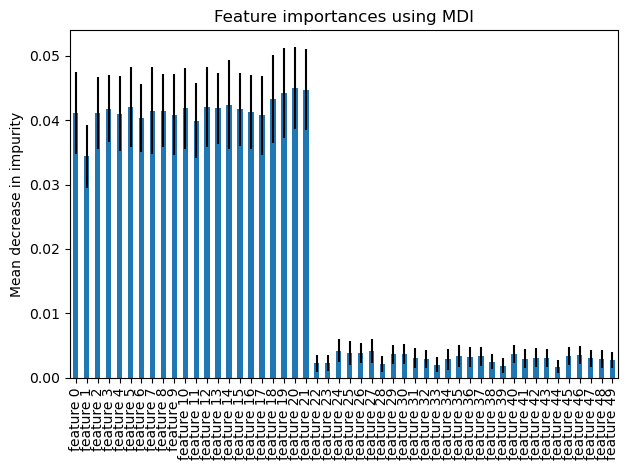

In [135]:
import time
import numpy as np

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_spread = RandomForestClassifier(random_state=0)
forest_spread.fit(X_train, y_train_spread)

start_time = time.time()
importances_spread = forest_spread.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_spread.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_spread_importances = pd.Series(importances_spread, index=feature_names)

fig, ax = plt.subplots()
forest_spread_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Elapsed time to compute the importances: 0.020 seconds


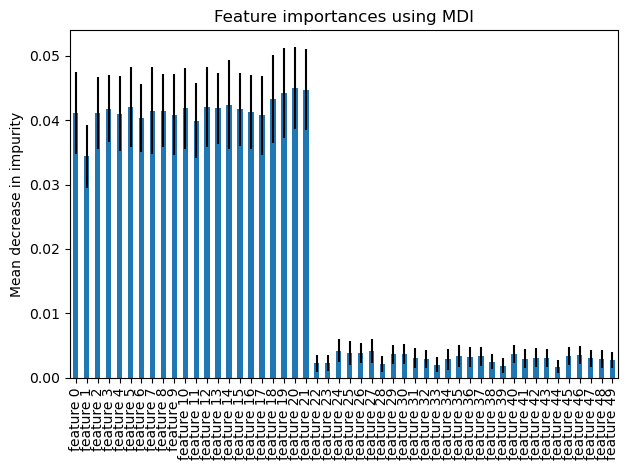

In [136]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_ou = RandomForestClassifier(random_state=0)
forest_ou.fit(X_train, y_train_spread)

start_time = time.time()
importances_ou = forest_ou.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_ou.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_ou_importances = pd.Series(importances_ou, index=feature_names)

fig, ax = plt.subplots()
forest_ou_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Elapsed time to compute the importances: 0.016 seconds


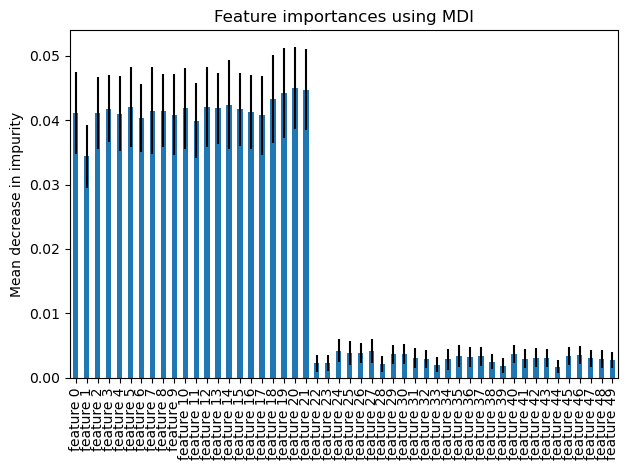

In [137]:
feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest_w = RandomForestClassifier(random_state=0)
forest_w.fit(X_train, y_train_spread)

start_time = time.time()
importances_w = forest_w.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest_w.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_w_importances = pd.Series(importances_w, index=feature_names)

fig, ax = plt.subplots()
forest_w_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Creation of pipeline for each prediction label (spread, over/under, underdog win)

In [138]:
pipeline_spread = Pipeline([
    ('scaler_spread', StandardScaler()),
    ('model_spread', RandomForestClassifier(
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features='sqrt',
        n_estimators=300
    ))])

pipeline_spread.fit(X_train, y_train_spread)
y_pred_spread = pipeline_spread.predict(X_test)

dump(X_train.columns.tolist(), 'models/spread_feature_names.pkl')

['models/spread_feature_names.pkl']

In [139]:
pipeline_ou = Pipeline([
    ('scaler_ou', StandardScaler()),
    ('model_ou', LogisticRegression(
        max_iter=5000,
        C=0.01,
        penalty='l2',
        solver='liblinear'
    ))
])

pipeline_ou.fit(X_train, y_train_ou)
y_pred_ou = pipeline_ou.predict(X_test)

dump(X_train.columns.tolist(), 'models/ou_feature_names.pkl')

['models/ou_feature_names.pkl']

In [140]:
pipeline_w = Pipeline([
    ('scaler_w', StandardScaler()),
    ('model_w', LogisticRegression(
        max_iter=5000,
        C=0.1,
        penalty='l2',
        solver='saga'
    ))
])

pipeline_w.fit(X_train, y_train_w)
y_pred_w = pipeline_w.predict(X_test)

dump(X_train.columns.tolist(), 'models/w_feature_names.pkl')

['models/w_feature_names.pkl']

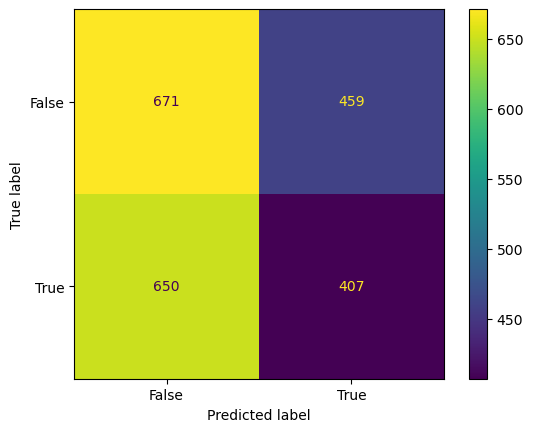

In [141]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipeline_ou, X_test, y_test_ou)

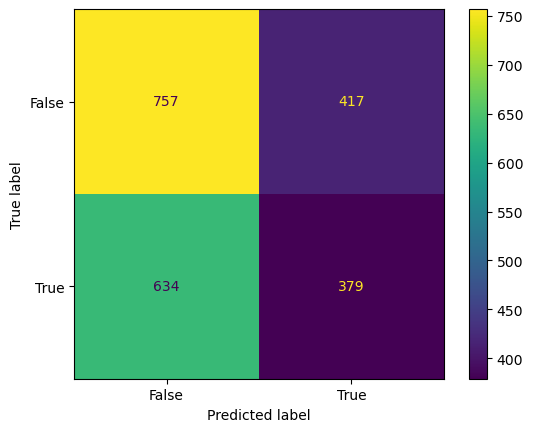

In [142]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipeline_spread, X_test, y_test_spread)

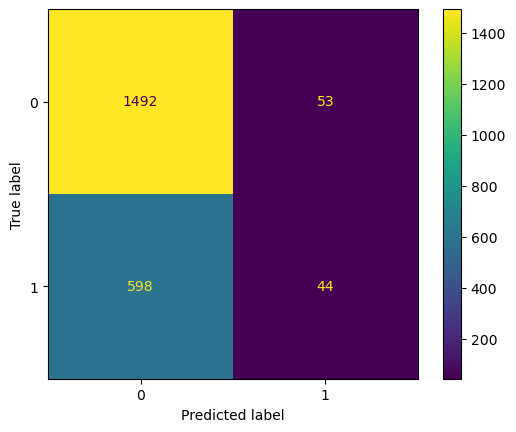

In [143]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(pipeline_w, X_test, y_test_w)

In [144]:
dump(pipeline_spread, 'models/pipeline_spread.pkl')
dump(pipeline_ou, 'models/pipeline_ou.pkl')
dump(pipeline_w, 'models/pipeline_w.pkl')

['models/pipeline_w.pkl']

In [ ]:
def build_feature_vector(team_home, team_away, game_date, rivalry, spread, ou_total, fav_side, ml_fav, ml_dog, data_source):
    """
    Constructs a model-ready feature vector for a single game.

    Parameters:
        team_home (str): Home team name
        team_away (str): Away team name
        game_date (datetime or str): Date of game for stat cutoff
        spread (float): Spread line
        ou_total (float): Over/under line
        fav_side (str): 'home' or 'away'
        data_source (pd.DataFrame): Historical stats table (season averages, matchups, etc.)

    Returns:
        pd.DataFrame: Single-row DataFrame with all engineered features
    """

    excluded_cols = ['season', 'week', 'time_et', 'game_type', 'neutral', 'spread_away_cover', 'spread_home_cover', 'home', 'away', 'full_date', 'game_id', 'conf_home', 'conf_away', 'rivalry', 'fav_side', 'dog_side']

    # Filter for team stats up to the given date
    home_stats = data_source[(data_source['home'] == team_home) & (data_source['full_date'] < game_date)]
    away_stats = data_source[(data_source['away'] == team_away) & (data_source['full_date'] < game_date)]

    # Aggregate averages
    home_avg = home_stats.mean(numeric_only=True)
    away_avg = away_stats.mean(numeric_only=True)

    for col, val in home_avg.items():
        if col not in excluded_cols:
            home_stats[f'{col}'] = val
    
    for col, val in away_avg.items():
        if col not in excluded_cols:
            away_stats[f'{col}'] = val  

    full_stats = pd.concat([home_stats, away_stats], axis=0)
    stats_means = full_stats.mean(numeric_only=True)

    # Build feature dict
    row = {
        'spread': spread,
        'ou_total': ou_total,
        'ml_fav': ml_fav,
        'ml_dog': ml_dog,
        'fav_side_home': 1 if fav_side == 'home' else 0,
        'fav_side_away': 1 if fav_side == 'away' else 0,
        'rivalry_y': 1 if 'rivalry' == 'y' else 0,
        'rivalry_n': 1 if 'rivalry' == 'n' else 0
    }

    row.update(stats_means.to_dict())

    # Convert to DataFrame and fill missing columns as needed
    row_df = pd.DataFrame([row])
    return row_df

In [146]:
champ_2025 = build_feature_vector(
    team_home='Notre Dame',
    team_away='Ohio State',
    game_date='2025-01-20',
    rivalry='n',
    spread=8.5,
    ou_total=45.0,
    ml_fav=-370,
    ml_dog=1141,
    fav_side='away',
    data_source=merged_df
)

C:\Users\gland\AppData\Local\Temp\ipykernel_10128\2158149554.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_stats[f'{col}'] = val
C:\Users\gland\AppData\Local\Temp\ipykernel_10128\2158149554.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_stats[f'{col}'] = val


In [ ]:
# Load trained pipeline (already fitted and saved)
from joblib import load
expected_spread_cols = load('models/spread_feature_names.pkl')
expected_ou_cols = load('models/ou_feature_names.pkl')
expected_underdog_cols = load('models/w_feature_names.pkl')

# Align and fill prediction row
for col in expected_spread_cols:
    if col not in champ_2025.columns:
        champ_2025[col] = 0

for col in expected_ou_cols:
    if col not in champ_2025.columns:
        champ_2025[col] = 0

for col in expected_underdog_cols:
    if col not in champ_2025.columns:
        champ_2025[col] = 0

pipeline_spread = load('models/pipeline_spread.pkl')
pipeline_ou = load('models/pipeline_ou.pkl')
pipeline_w = load('models/pipeline_w.pkl')

# Run prediction
champ_spread_ready = champ_2025[expected_spread_cols]
champ_ou_ready = champ_2025[expected_ou_cols]
champ_w_ready = champ_2025[expected_underdog_cols]

pred_spread = pipeline_spread.predict(champ_spread_ready)
pred_ou = pipeline_ou.predict(champ_ou_ready)
pred_w = pipeline_w.predict(champ_w_ready)


# Load expected feature schema for each model
spread_cols    = load('models/spread_feature_names.pkl')
ou_cols        = load('models/ou_feature_names.pkl')
underdog_cols  = load('models/w_feature_names.pkl')

# Align input for each model
def align(row_df, feature_list):
    for col in feature_list:
        if col not in row_df.columns:
            row_df[col] = 0
    return row_df[feature_list]

champ_spread    = align(champ_2025, spread_cols)
champ_ou        = align(champ_2025, ou_cols)
champ_underdog  = align(champ_2025, underdog_cols)

# Predict
pred_spread   = pipeline_spread.predict(champ_spread)[0]
proba_spread  = pipeline_spread.predict_proba(champ_spread)[0]

pred_ou       = pipeline_ou.predict(champ_ou)[0]
proba_ou      = pipeline_ou.predict_proba(champ_ou)[0]

pred_dog      = pipeline_w.predict(champ_underdog)[0]
proba_dog     = pipeline_w.predict_proba(champ_underdog)[0]

# Output
print(f"🏈 Predicted Outcome (Spread): {pred_spread}")
print(f"📊 Probabilities (Spread): {proba_spread}")

# Output
print(f"🏈 Predicted Outcome (Over/Under): {pred_ou}")
print(f"📊 Probabilities (Over/Under): {proba_ou}")

# Output
print(f"🏈 Predicted Outcome (Underdog): {pred_dog}")
print(f"📊 Probabilities (Underdog): {proba_dog}")

🏈 Predicted Outcome (Spread): False
📊 Probabilities (Spread): [0.58932937 0.41067063]
🏈 Predicted Outcome (Over/Under): False
📊 Probabilities (Over/Under): [0.525206 0.474794]
🏈 Predicted Outcome (Underdog): 0
📊 Probabilities (Underdog): [0.76079047 0.23920953]
